# “The Middlegame”
 ## Part_1:  Tactics - Analyzing the dataset


In [1]:
# increase the width of the notebook
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
# extra code – the next lines define the default font sizes
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rcParams.update({'font.size': 12})

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

In [4]:
# code to save the figures as high-res PNGs 

IMAGES_PATH = Path() / "images" / "main_analysis"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

### Importing and exploring the dataset

In [5]:
data_bulk = pd.read_csv("games_bulk.csv",sep=",")
data_bulk = data_bulk.drop(columns=["Game#"])
data = data_bulk.drop_duplicates().copy()
data = data.reset_index(drop=True)
print(f"Removed {len(data_bulk) - len(data)} duplicate rows.")

Removed 118 duplicate rows.


In [6]:
print(data.columns.tolist()) # Some whitespace needs to be cleaned 
data.columns = data.columns.str.strip()

['Time_format', 'Date ', 'White ', 'Black ', 'Result ', 'UTCDate ', 'WhiteElo ', 'BlackElo ', 'Variant ', 'TimeControl', 'Increment', 'ECO ', 'Termination ', 'Opening_name', 'Increment_binary']


In [7]:
data.head()

,Time_format,Date,White,Black,Result,UTCDate,WhiteElo,BlackElo,Variant,TimeControl,Increment,ECO,Termination,Opening_name,Increment_binary
0,rapid,2025.01.16,acoacoaco,sen_python,0-1,2025.01.16,1164,1159,Standard,600,0,A16,Time forfeit,English Opening,No
1,rapid,2025.01.15,acoacoaco,Mr_Brandenburg,1-0,2025.01.15,1162,1201,Standard,600,0,A16,Normal,English Opening,No
2,rapid,2025.01.10,acoacoaco,defose84,0-1,2025.01.10,1154,1150,Standard,600,0,A16,Normal,English Opening,No
3,rapid,2024.12.30,acoacoaco,christym91,1-0,2024.12.30,1186,1186,Standard,600,0,A16,Normal,English Opening,No
4,rapid,2024.12.27,acoacoaco,sylwek1984,0-1,2024.12.27,1181,1221,Standard,600,0,A16,Time forfeit,English Opening,No


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167952 entries, 0 to 167951
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Time_format       167952 non-null  object
 1   Date              167950 non-null  object
 2   White             167951 non-null  object
 3   Black             167949 non-null  object
 4   Result            167952 non-null  object
 5   UTCDate           167949 non-null  object
 6   WhiteElo          167952 non-null  int64 
 7   BlackElo          167952 non-null  int64 
 8   Variant           167952 non-null  object
 9   TimeControl       167952 non-null  int64 
 10  Increment         167952 non-null  int64 
 11  ECO               167952 non-null  object
 12  Termination       167935 non-null  object
 13  Opening_name      167952 non-null  object
 14  Increment_binary  167952 non-null  object
dtypes: int64(4), object(11)
memory usage: 19.2+ MB


### Let's check some basic stats about Elo and its distribution.

In [9]:
data[["WhiteElo","BlackElo"]].describe()

,WhiteElo,BlackElo
count,167952.000000,167952.000000
mean,2097.487431,2097.451468
std,491.896193,491.888561
min,494.000000,453.000000
25%,1877.000000,1876.000000
50%,2111.000000,2111.000000
75%,2372.000000,2372.000000
max,3377.000000,3379.000000


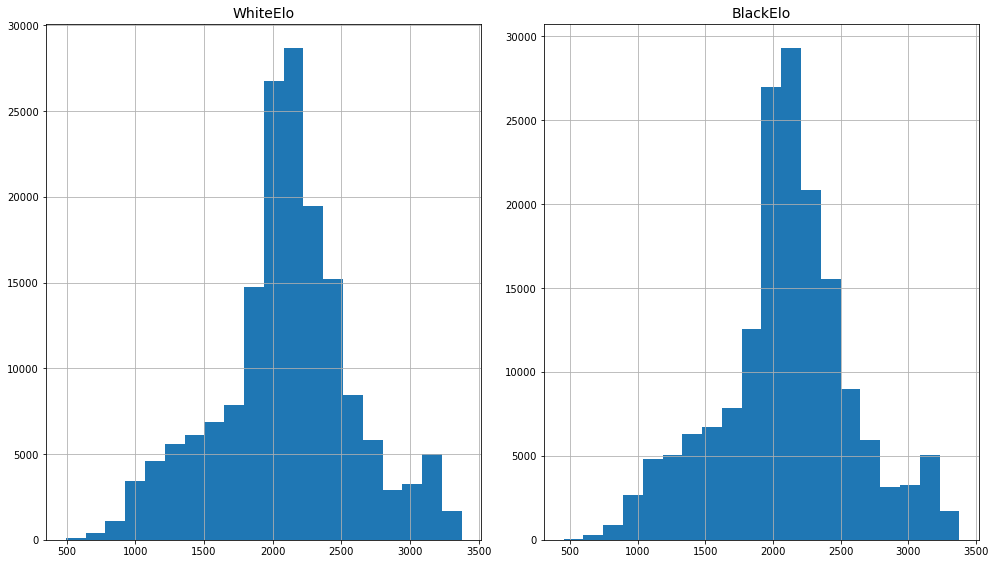

In [10]:
data[["WhiteElo","BlackElo"]].hist(bins=20,figsize=(14,8))
save_fig("Elo_hist")
plt.show()

### Creating three new columns to help us with analysis 

In [11]:
# Define Elo rating ranges
elo_bins = [0, 1000, 1300, 1600, 1800, 2000, 2200, 2400, 2600, np.inf]
elo_labels = ["<1000", "1000-1300", "1300-1600", "1600-1800", "1800-2000", "2000-2200", "2200-2400", "2400-2600","2600+"]

# Creating new columns for Elo ranges and Elo differences
data["Elo_Range"] = pd.cut(data["WhiteElo"], bins=elo_bins, labels=elo_labels)
data["EloDif"] = data["WhiteElo"] - data["BlackElo"]

In [12]:
# Define mapping for result to score
result_to_score = {
    "1-0": 1,       
    "1/2-1/2": 0.5, 
    "0-1": 0        
}

# Apply mapping to create the 'Score' column
data["Score"] = data["Result"].map(result_to_score)

### Checking the stats for "EloDif"

In [13]:
data["EloDif"].describe()

count    167952.000000
mean          0.035963
std         108.451386
min       -1604.000000
25%         -47.000000
50%           0.000000
75%          47.000000
max        1705.000000
Name: EloDif, dtype: float64

### Boxplot for Elo difference

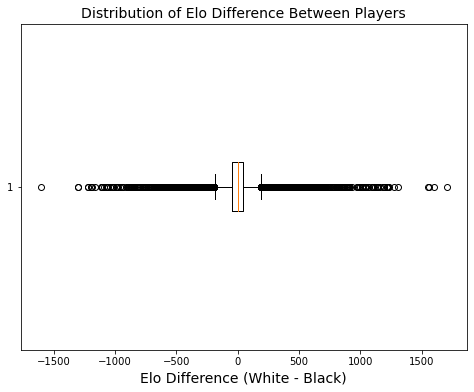

In [14]:
plt.figure(figsize=(8, 6))  
plt.boxplot(data["EloDif"], vert=False)  # Create the boxplot, `vert=False` makes it horizontal
plt.xlabel("Elo Difference (White - Black)")  
plt.title("Distribution of Elo Difference Between Players")  
plt.show()

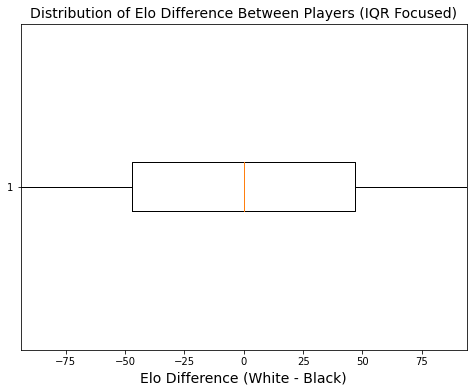

In [15]:
plt.figure(figsize=(8, 6))

# Calculate quartiles
Q1 = data["EloDif"].quantile(0.25)
Q3 = data["EloDif"].quantile(0.75)
IQR = Q3 - Q1

# Set whisker limits
lower_bound = Q1
upper_bound = Q3

# Create the boxplot, showing only points within the IQR
plt.boxplot(data["EloDif"], vert=False, showfliers=False)  # showfliers=False hides outliers

# Set axis limits to focus on IQR
plt.xlim(lower_bound - 0.5 * IQR, upper_bound + 0.5 * IQR) # Adjust 0.5 as needed

plt.xlabel("Elo Difference (White - Black)")
plt.title("Distribution of Elo Difference Between Players (IQR Focused)")
plt.show()

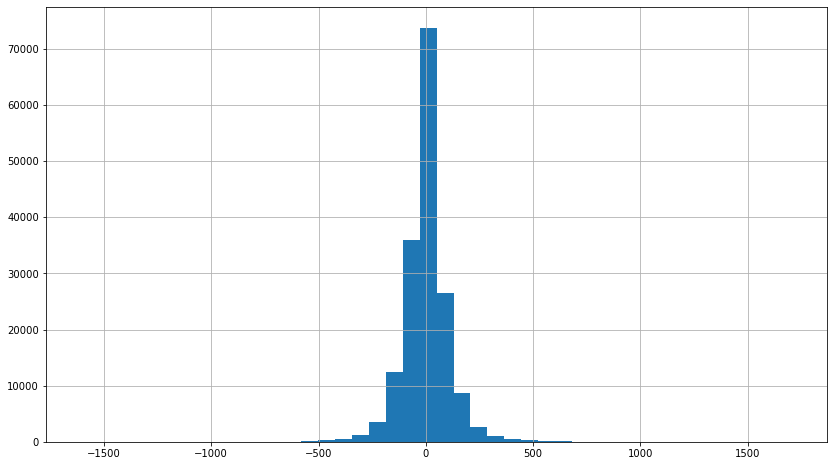

In [16]:
data["EloDif"].hist(bins=42,figsize=(14,8))
#save_fig("EloDif_hist")
plt.show()

In [17]:
# Define Elo difference rating ranges
dif_bins = [-np.inf, -400, -200, -100, -50, -20, 20, 50, 100, 200, 400, np.inf]
dif_labels = ["Crushing Black Advantage","Strong Black Advantage","Moderate Black Advantage",
              "Slight Black Advantage","Minimal Black Edge","Balanced / Even",
    "Minimal White Edge",
    "Slight White Advantage",
    "Moderate White Advantage",
    "Strong White Advantage",
    "Crushing White Advantage"]


data["Elo_Dif_Range"] = pd.cut(data["EloDif"], bins=dif_bins, labels=dif_labels)

In [18]:
data.head()

,Time_format,Date,White,Black,Result,UTCDate,WhiteElo,BlackElo,Variant,TimeControl,Increment,ECO,Termination,Opening_name,Increment_binary,Elo_Range,EloDif,Score,Elo_Dif_Range
0,rapid,2025.01.16,acoacoaco,sen_python,0-1,2025.01.16,1164,1159,Standard,600,0,A16,Time forfeit,English Opening,No,1000-1300,5,0.0,Balanced / Even
1,rapid,2025.01.15,acoacoaco,Mr_Brandenburg,1-0,2025.01.15,1162,1201,Standard,600,0,A16,Normal,English Opening,No,1000-1300,-39,1.0,Minimal Black Edge
2,rapid,2025.01.10,acoacoaco,defose84,0-1,2025.01.10,1154,1150,Standard,600,0,A16,Normal,English Opening,No,1000-1300,4,0.0,Balanced / Even
3,rapid,2024.12.30,acoacoaco,christym91,1-0,2024.12.30,1186,1186,Standard,600,0,A16,Normal,English Opening,No,1000-1300,0,1.0,Balanced / Even
4,rapid,2024.12.27,acoacoaco,sylwek1984,0-1,2024.12.27,1181,1221,Standard,600,0,A16,Time forfeit,English Opening,No,1000-1300,-40,0.0,Minimal Black Edge


# 1. What is the distribution of outcomes (white wins, draw, black wins) in the dataset?


Percentage of Games by Result:

1-0        49.00
0-1        45.36
1/2-1/2     5.63
Name: Result, dtype: float64


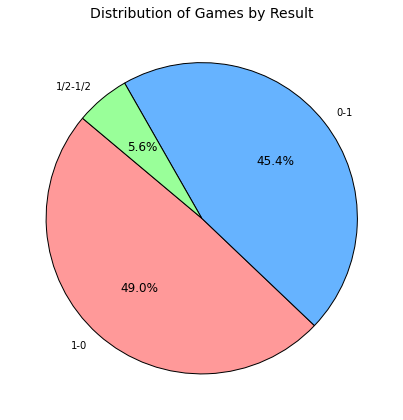

In [19]:
# Count occurrences of each time format
Result_counts = data["Result"].value_counts()

# Calculate percentages
Result_percentages = (Result_counts / Result_counts.sum()) * 100

# Print percentages
print("\nPercentage of Games by Result:\n")
print(Result_percentages.round(2))

# Plot pie chart
plt.figure(figsize=(6, 6))
plt.pie(Result_counts, labels= Result_counts.index, autopct="%1.1f%%", colors=["#ff9999","#66b3ff","#99ff99","#ffcc99"],
        startangle=140, wedgeprops={'edgecolor': 'black'})

plt.title("Distribution of Games by Result")
save_fig("Results_pie_chart")
plt.show()

# 2. How do player Elo rating ranges correlate with game outcomes?

In [20]:
# Count occurrences of results within each Elo range
elo_result_counts = data.groupby(["Elo_Range", "Result"]).size().unstack()
result_order = ["1-0", "0-1", "1/2-1/2"]
elo_result_counts = elo_result_counts[result_order]

# Calculate percentages
elo_result_percentages = elo_result_counts.div(elo_result_counts.sum(axis=1), axis=0) * 100

# Print percentages
print("\nPercentage of Game Results Per Elo Range:\n")
print(elo_result_percentages.round(2))


Percentage of Game Results Per Elo Range:

Result       1-0    0-1  1/2-1/2
Elo_Range                       
<1000      47.70  46.05     6.26
1000-1300  50.74  47.34     1.92
1300-1600  48.90  48.43     2.67
1600-1800  48.31  48.73     2.96
1800-2000  47.94  47.59     4.47
2000-2200  49.04  45.37     5.59
2200-2400  48.24  44.63     7.13
2400-2600  48.82  43.18     8.01
2600+      51.14  40.84     8.01


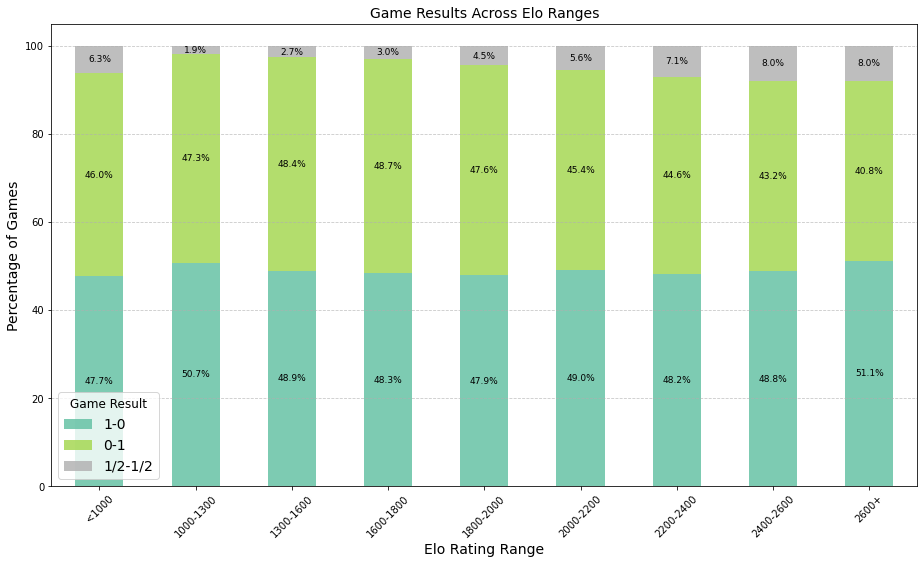

<Figure size 432x288 with 0 Axes>

In [21]:
fig, ax = plt.subplots(figsize=(13, 8))  # Create figure and axes

elo_result_percentages.plot(kind="bar", stacked=True, colormap="Set2", alpha=0.85, ax=ax) #Use the ax created

# Customize plot (use ax to refer to axes)
ax.set_xlabel("Elo Rating Range")
ax.set_ylabel("Percentage of Games")  
ax.set_title("Game Results Across Elo Ranges")
ax.tick_params(axis='x', rotation=45) #Use ax to refer to axes
ax.legend(title="Game Result")
ax.grid(axis="y", linestyle="--", alpha=0.7)

# Add percentage labels inside the bars
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    ax.annotate(f'{height:.1f}%', (x + width/2, y + height/2), ha='center', va='center', fontsize=9, color='black') #Adjust fontsize as needed

plt.tight_layout()
plt.show()


plt.tight_layout() 
save_fig("Game Results Across Elo Ranges")
plt.show()

# 3.	What are the most common openings, and how do they relate to game outcomes?

In [22]:
opening_counts = data["Opening_name"].value_counts()

opening_percentages = (opening_counts / opening_counts.sum()) * 100

print("\nPercentage of Games by Opening Name:\n")
print(opening_percentages.head(25).round(2))


Percentage of Games by Opening Name:

Sicilian defense                                 17.96
Queen's Pawn Game                                10.92
French Defense                                    6.80
English Opening                                   6.40
Caro-Kann defense                                 4.77
Irregular Openings                                4.56
Queen's Gambit                                    4.24
Scandinavian Defense (Center-Counter Defense)     3.78
Closed Game, Irregular Responses                  3.26
Zukertort Opening                                 3.02
King's Pawn Opening, Irregular Defenses           2.65
King's Gambit                                     2.49
Petrov's Defense                                  1.99
Alekhine's defense                                1.92
King's Pawn Game                                  1.83
Ruy Lopez                                         1.79
Larsen's Opening                                  1.61
Robatsch (Modern) defense 

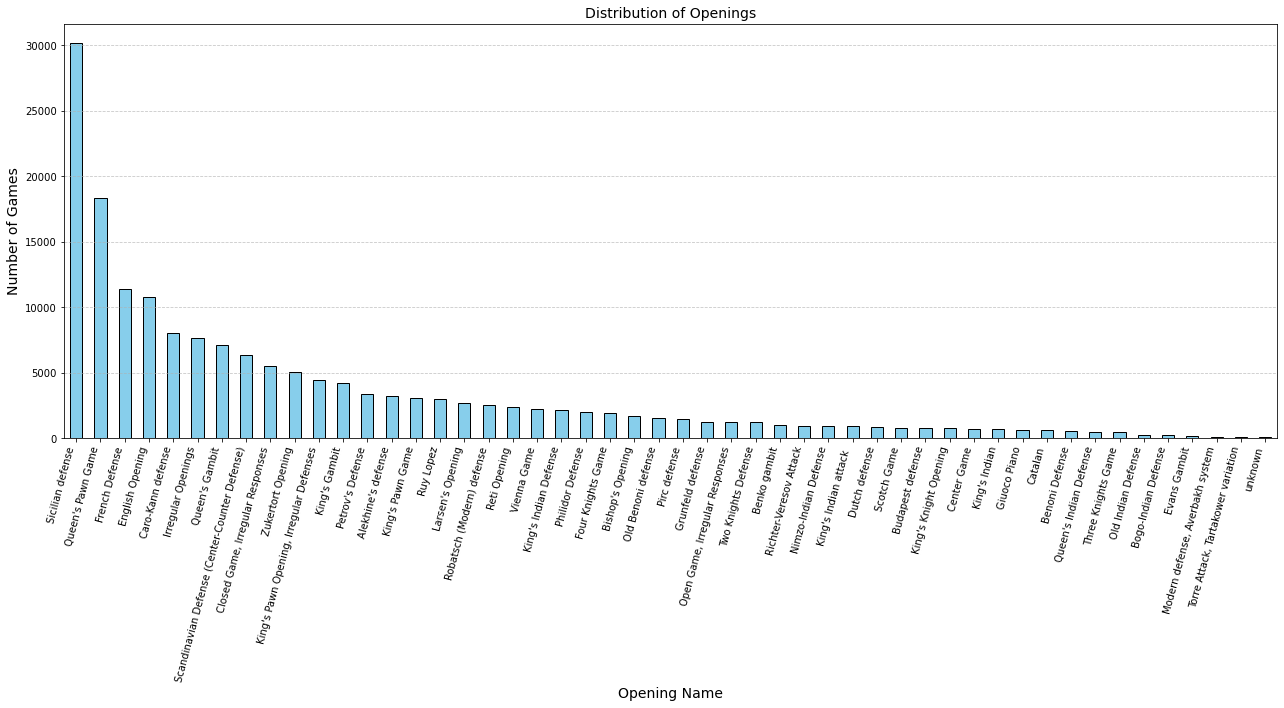

In [23]:
# Plot bar chart
plt.figure(figsize=(18, 10))
opening_counts.sort_values(ascending=False).plot(kind="bar", color="skyblue", edgecolor="black")

plt.xlabel("Opening Name")
plt.ylabel("Number of Games")
plt.title("Distribution of Openings")
plt.xticks(rotation=75, ha="right")  
plt.grid(axis="y", linestyle="--", alpha=0.7)

save_fig("Distribution of Openings")
plt.show()


### Get the most common openings (top 10)


Win/Loss Distribution for Top Openings:

Result                                           1-0    0-1  1/2-1/2
Opening_name                                                        
Caro-Kann defense                              49.61  44.32     6.07
Closed Game, Irregular Responses               51.13  44.01     4.85
English Opening                                49.45  44.40     6.15
French Defense                                 48.88  46.08     5.04
Irregular Openings                             49.12  46.26     4.62
Queen's Gambit                                 47.91  45.64     6.45
Queen's Pawn Game                              49.29  45.65     5.06
Scandinavian Defense (Center-Counter Defense)  46.87  48.21     4.93
Sicilian defense                               48.39  45.62     5.99
Zukertort Opening                              48.34  44.99     6.66


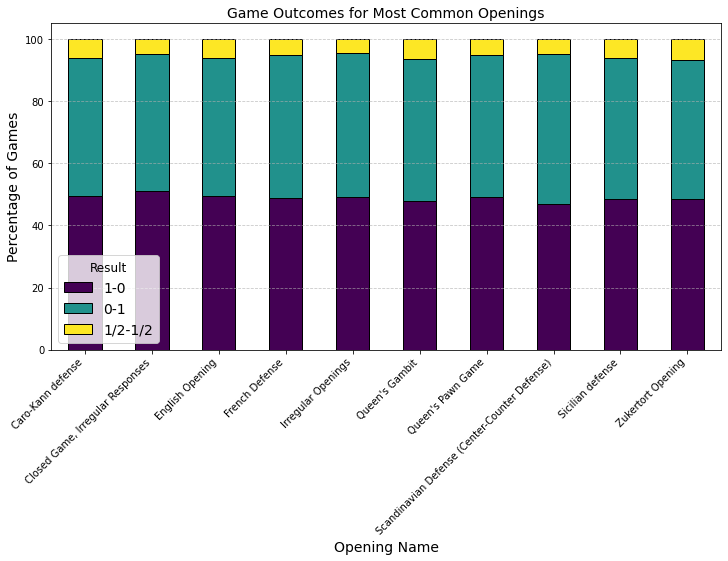

In [24]:
top_openings = data["Opening_name"].value_counts().head(10).index

# Filter dataset for only these openings
filtered_data = data[data["Opening_name"].isin(top_openings)]

# Count occurrences of each result per opening
opening_results = filtered_data.groupby(["Opening_name", "Result"]).size().unstack()
opening_results=opening_results[result_order]
# Convert to percentages per opening
opening_results_percentage = opening_results.div(opening_results.sum(axis=1), axis=0) * 100

# Print percentages
print("\nWin/Loss Distribution for Top Openings:\n")
print(opening_results_percentage.round(2))

# Plot the results
opening_results_percentage.plot(kind="bar", stacked=True, figsize=(12, 6), colormap="viridis", edgecolor="black")

# Customize plot
plt.xlabel("Opening Name")
plt.ylabel("Percentage of Games")
plt.title("Game Outcomes for Most Common Openings")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Result")
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show plot
plt.show()

### Filtering for "Scandinavian Defense'

In [25]:
grouped = data.groupby(["Elo_Range", "Opening_name", "Result"]).size().unstack()
grouped = grouped[result_order]
grouped_percentage = grouped.div(grouped.sum(axis=1), axis=0) * 100

In [26]:
grouped_percentage.loc[grouped.index.get_level_values("Opening_name") == "Scandinavian Defense (Center-Counter Defense)"].round(2)

,Result,1-0,0-1,1/2-1/2
Elo_Range,Opening_name,,,
<1000,Scandinavian Defense (Center-Counter Defense),35.43,54.29,10.29
1000-1300,Scandinavian Defense (Center-Counter Defense),45.98,50.57,3.45
1300-1600,Scandinavian Defense (Center-Counter Defense),45.61,51.25,3.15
1600-1800,Scandinavian Defense (Center-Counter Defense),46.44,48.74,4.82
1800-2000,Scandinavian Defense (Center-Counter Defense),48.39,48.63,2.97
2000-2200,Scandinavian Defense (Center-Counter Defense),46.09,49.13,4.78
2200-2400,Scandinavian Defense (Center-Counter Defense),50.48,41.94,7.58
2400-2600,Scandinavian Defense (Center-Counter Defense),57.08,36.05,6.87
2600+,Scandinavian Defense (Center-Counter Defense),45.79,47.51,6.70


### 4.	What's the breakdown of time formats and time increments? And how do these  affect game results and how the game ends (termnination)



Percentage of Games by Time Format:

 bullet        38.99
 blitz         36.65
 rapid         20.03
 classical      4.34
Name: Time_format, dtype: float64


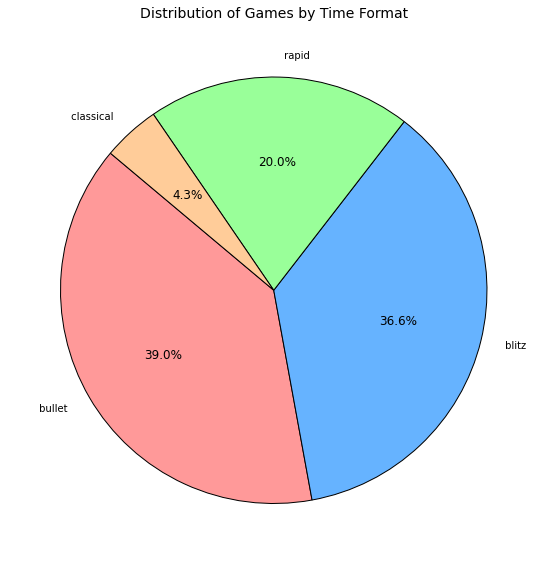

In [27]:
time_format_counts = data["Time_format"].value_counts()
time_format_percentages = (time_format_counts / time_format_counts.sum()) * 100

# Print percentages
print("\nPercentage of Games by Time Format:\n")
print(time_format_percentages.round(2))

# Plot pie chart
plt.figure(figsize=(8, 8))
plt.pie(time_format_counts, labels=time_format_counts.index, autopct="%1.1f%%", colors=["#ff9999","#66b3ff","#99ff99","#ffcc99"],
        startangle=140, wedgeprops={'edgecolor': 'black'})
plt.title("Distribution of Games by Time Format")

save_fig("PieChart of Games by Time Format")
plt.show()

In [28]:
# Group by Time_format and Increment_binary, then calculate percentages
increment_percentage = data.groupby("Time_format")["Increment_binary"].value_counts(normalize=True) * 100

# Convert to a DataFrame for better readability
increment_percentage = increment_percentage.unstack()

# Print the percentage table
print("\nPercentage of Increment per Time_format:\n")
print(increment_percentage.round(2))  


Percentage of Increment per Time_format:

Increment_binary     No    Yes
Time_format                   
 blitz            58.55  41.45
 bullet           83.60  16.40
 classical        72.18  27.82
 rapid            81.19  18.81


In [29]:
# Group by Increment_binary and Termination, then calculate percentages
termnination_percentage = data.groupby("Increment_binary")["Termination"].value_counts(normalize=True) * 100

# Convert to a DataFrame for better readability
termnination_percentage = termnination_percentage.unstack()

# Print the percentage table
print("\nPercentage of Termination per Increment_binary:\n")
print(termnination_percentage.round(2))


Percentage of Termination per Increment_binary:

Termination       Abandoned  Normal  Time forfeit
Increment_binary                                 
No                     0.02   71.54         28.44
Yes                    0.02   80.68         19.30


In [30]:
# Count occurrences of results within each Time format
time_result_counts = data.groupby(["Time_format", "Result"]).size().unstack()
time_result_counts = time_result_counts[result_order]

# Calculate percentages
time_result_percentages = time_result_counts.div(time_result_counts.sum(axis=1), axis=0) * 100

# Print percentages
print("\nPercentage of Game Results Per Time format:\n")
print(time_result_percentages.round(2))


Percentage of Game Results Per Time format:

Result         1-0    0-1  1/2-1/2
Time_format                       
 blitz       48.41  44.92     6.66
 bullet      49.51  45.92     4.57
 classical   48.71  44.47     6.82
 rapid       49.15  45.29     5.56


### 5.	How does the time format affect game results for players with different Elo ratings?

In [31]:
# Group by Elo Range, Time format, and Result
grouped = data.groupby(["Elo_Range", "Time_format", "Result"]).size().unstack()
grouped=grouped[result_order]
# Convert to percentages
grouped_percentage = grouped.div(grouped.sum(axis=1), axis=0) * 100

# Loop through each Elo Range and print results
print("\nWin/Loss Distribution for Time_format per Elo Range:\n")

for elo_range in grouped_percentage.index.get_level_values(0).unique():
    print(f"\nElo Range: {elo_range}\n")
    df_subset = grouped_percentage.loc[elo_range].fillna(0)  # Fill NaN with 0
    
    # Sort by win percentage in descending order
    df_subset_sorted = df_subset.sort_values(by='1-0', ascending=False)  # Sort by 'Win'

    print(df_subset_sorted.round(2))
    print("-" * 50)


Win/Loss Distribution for Time_format per Elo Range:


Elo Range: <1000

Result         1-0    0-1  1/2-1/2
Time_format                       
 rapid       50.90  48.25     0.85
 classical   47.65  45.88     6.47
 bullet      46.05  52.63     1.32
 blitz       46.02  44.19     9.79
--------------------------------------------------

Elo Range: 1000-1300

Result         1-0    0-1  1/2-1/2
Time_format                       
 classical   52.07  42.28     5.65
 rapid       51.23  47.43     1.34
 bullet      50.47  48.18     1.35
 blitz       48.66  47.02     4.32
--------------------------------------------------

Elo Range: 1300-1600

Result         1-0    0-1  1/2-1/2
Time_format                       
 classical   52.20  43.25     4.55
 rapid       50.77  46.33     2.90
 bullet      47.83  50.16     2.01
 blitz       47.12  49.35     3.52
--------------------------------------------------

Elo Range: 1600-1800

Result         1-0    0-1  1/2-1/2
Time_format                       
 bul

### 6.	How does the Elo difference vary across outcomes?

In [32]:
elo_outcome_stats = data.groupby("Result")["EloDif"].mean()
print("\nElo Difference Mean by Game Outcome:")
print(elo_outcome_stats)


Elo Difference Mean by Game Outcome:
Result
0-1       -21.678799
1-0        20.445631
1/2-1/2    -2.634087
Name: EloDif, dtype: float64


### 7.	How does the Elo difference relate to game outcomes?

In [33]:
# Count occurrences of results within each Elo range
elo_Dif_result_counts = data.groupby(["Elo_Dif_Range", "Result"]).size().unstack(fill_value=0)
result_order = ["1-0", "0-1", "1/2-1/2"]
elo_Dif_result_counts = elo_Dif_result_counts[result_order]

# Calculate percentages
elo_Dif_result_percentages = elo_Dif_result_counts.div(elo_Dif_result_counts.sum(axis=1), axis=0) * 100

# Print percentages
print("\nPercentage of Game Results Per Elo Difference Range:\n")
print(elo_Dif_result_percentages.round(2))


Percentage of Game Results Per Elo Difference Range:

Result                      1-0    0-1  1/2-1/2
Elo_Dif_Range                                  
Crushing Black Advantage  16.11  80.81     3.09
Strong Black Advantage    25.20  68.15     6.65
Moderate Black Advantage  35.11  58.07     6.82
Slight Black Advantage    41.42  52.56     6.02
Minimal Black Edge        45.69  48.97     5.34
Balanced / Even           49.29  45.65     5.06
Minimal White Edge        52.54  42.07     5.39
Slight White Advantage    56.57  37.61     5.82
Moderate White Advantage  62.37  31.51     6.12
Strong White Advantage    73.06  21.63     5.31
Crushing White Advantage  80.24  15.09     4.67


###  Filtering the loses of the crushing players

In [34]:
data.to_csv("data.csv", index=False) #save the dataset for hypothesis testing

In [35]:
# Filter the dataset
crushing_white_lost = data[
    (data["Elo_Dif_Range"] == "Crushing White Advantage") &  # White had a huge Elo advantage
    (data["Result"] == "0-1")  # White lost (Black won)
]

# Calculate percentage of games by Time Format
time_format_percentage = crushing_white_lost["Time_format"].value_counts(normalize=True) * 100
openings_percentage = crushing_white_lost["Opening_name"].value_counts(normalize=True) * 100
# Print the percentages
print("\nPercentage of Crushing White Advantage losses per Time Format:\n")
print(time_format_percentage.round(2))

print("\nPercentage of Crushing White Advantage losses per Opening:\n")
print(openings_percentage.round(2))


Percentage of Crushing White Advantage losses per Time Format:

 blitz         59.29
 bullet        20.35
 classical     10.62
 rapid          9.73
Name: Time_format, dtype: float64

Percentage of Crushing White Advantage losses per Opening:

Sicilian defense                                 19.47
English Opening                                  11.50
King's Gambit                                     7.96
Queen's Pawn Game                                 7.08
French Defense                                    6.19
Caro-Kann defense                                 6.19
Ruy Lopez                                         3.54
Scandinavian Defense (Center-Counter Defense)     2.65
Vienna Game                                       2.65
Queen's Gambit                                    2.65
Zukertort Opening                                 2.65
King's Pawn Game                                  2.65
Robatsch (Modern) defense                         2.65
Irregular Openings                       

In [36]:
# Filter the dataset
crushing_black_lost = data[
    (data["Elo_Dif_Range"] == "Crushing Black Advantage") &  # Black had a huge Elo advantage
    (data["Result"] == "1-0")  # Black lost (White won)
]

# Calculate percentage of games by Time Format
time_format_percentage = crushing_black_lost["Time_format"].value_counts(normalize=True) * 100
openings_percentage = crushing_black_lost["Opening_name"].value_counts(normalize=True) * 100
# Print the percentages
print("\nPercentage of Crushing Black Advantage losses per Time Format:\n")
print(time_format_percentage.round(2))

print("\nPercentage of Crushing Black Advantage losses per Opening:\n")
print(openings_percentage.round(2))


Percentage of Crushing Black Advantage losses per Time Format:

 blitz         51.67
 bullet        25.00
 classical     12.50
 rapid         10.83
Name: Time_format, dtype: float64

Percentage of Crushing Black Advantage losses per Opening:

Sicilian defense                           27.50
Queen's Pawn Game                          11.67
Caro-Kann defense                           8.33
Queen's Gambit                              5.83
English Opening                             5.83
French Defense                              5.83
Irregular Openings                          5.00
Larsen's Opening                            4.17
Zukertort Opening                           2.50
King's Pawn Opening, Irregular Defenses     2.50
Ruy Lopez                                   2.50
Alekhine's defense                          2.50
Robatsch (Modern) defense                   2.50
Closed Game, Irregular Responses            2.50
Benoni Defense                              1.67
Scotch Game          

### Preparing the dataset for the ML phase

In [37]:
data = data[["WhiteElo","BlackElo","EloDif","Opening_name","Time_format","Increment_binary","Score" ]]

In [38]:
# Shuffle the DataFrame
shuffled_data = data.sample(frac=1, random_state=42)  # frac=1 shuffles all rows

# Keep only the first 80000 rows
shuffled_data_80k = shuffled_data.head(80000)

# Save the shuffled and truncated DataFrame to a CSV file
shuffled_data_80k.to_csv("data_ML.csv", index=False)  # index=False prevents saving the index column

In [39]:
shuffled_data_80k.head(8)

,WhiteElo,BlackElo,EloDif,Opening_name,Time_format,Increment_binary,Score
164821,1851,1901,-50,Alekhine's defense,classical,Yes,1.0
10670,2060,2111,-51,French Defense,blitz,Yes,0.0
40189,2307,2290,17,Philidor Defense,blitz,No,0.5
34478,2380,2419,-39,Sicilian defense,rapid,No,0.0
74357,2686,2848,-162,Ruy Lopez,rapid,No,0.0
106140,1902,2069,-167,Philidor Defense,rapid,No,0.0
6409,2101,2099,2,Queen's Pawn Game,blitz,Yes,1.0
33047,2279,2158,121,Queen's Pawn Game,blitz,No,0.0


### Let's compare the most important distributions in our processed data with those in the original dataset.

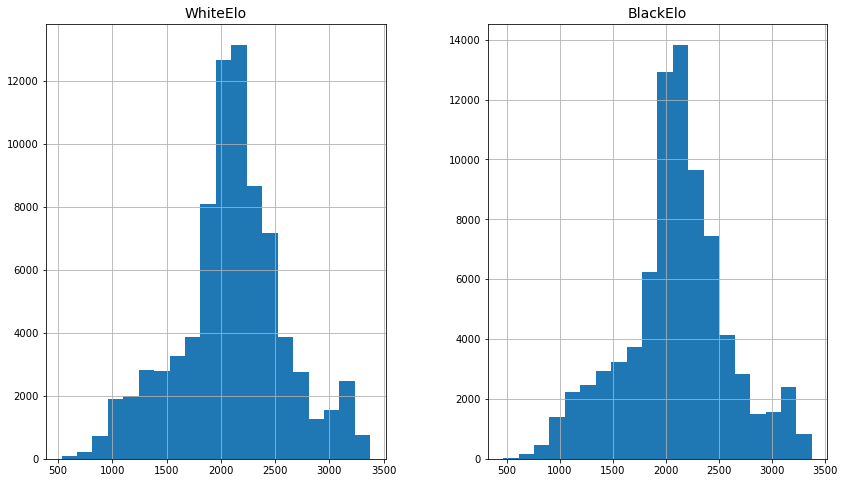

In [40]:
shuffled_data_80k[["WhiteElo","BlackElo"]].hist(bins=20,figsize=(14,8))
plt.show()

In [41]:
# Count occurrences of each time format
Result_counts = shuffled_data_80k["Score"].value_counts()

# Calculate percentages
Result_percentages = (Result_counts / Result_counts.sum()) * 100

# Print percentages
print("\nPercentage of shuffled_data_80k by Result:\n")
print(Result_percentages.round(2))


Percentage of shuffled_data_80k by Result:

1.0    49.10
0.0    45.24
0.5     5.66
Name: Score, dtype: float64


In [42]:
opening_counts = shuffled_data_80k["Opening_name"].value_counts()

opening_percentages = (opening_counts / opening_counts.sum()) * 100

print("\nPercentage of Games by Opening Name:\n")
print(opening_percentages.head(10).round(2))


Percentage of Games by Opening Name:

Sicilian defense                                 18.04
Queen's Pawn Game                                10.90
French Defense                                    6.75
English Opening                                   6.48
Caro-Kann defense                                 4.68
Irregular Openings                                4.46
Queen's Gambit                                    4.27
Scandinavian Defense (Center-Counter Defense)     3.81
Closed Game, Irregular Responses                  3.23
Zukertort Opening                                 2.97
Name: Opening_name, dtype: float64



Percentage of Games by Time Format:

 bullet        38.84
 blitz         36.82
 rapid         20.02
 classical      4.32
Name: Time_format, dtype: float64


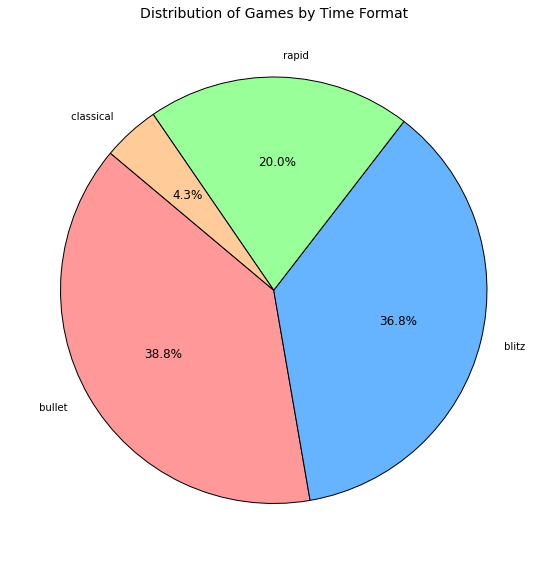

In [43]:
time_format_counts = shuffled_data_80k["Time_format"].value_counts()
time_format_percentages = (time_format_counts / time_format_counts.sum()) * 100

# Print percentages
print("\nPercentage of Games by Time Format:\n")
print(time_format_percentages.round(2))

# Plot pie chart
plt.figure(figsize=(8, 8))
plt.pie(time_format_counts, labels=time_format_counts.index, autopct="%1.1f%%", colors=["#ff9999","#66b3ff","#99ff99","#ffcc99"],
        startangle=140, wedgeprops={'edgecolor': 'black'})
plt.title("Distribution of Games by Time Format")

save_fig("PieChart of Games by Time Format")
plt.show()

### Everything looks good, and we're ready to move on to Part 2: Machine Learning algorithms! 